In [1]:
from tqdm.notebook import tqdm
import astropy.constants as const
import pylab as plt
from astropy.modeling import models
from astropy import units as u
from astropy.visualization import quantity_support
import numpy as np
import scipy.stats
import pylab as plt
import math
from scipy.stats import norm
import astropy
from astropy.modeling import models
from astropy import units as u
from astropy.modeling.models import BlackBody
from astropy.visualization import quantity_support

M_sun = const.M_sun.cgs.value

In [23]:
def max_mass(t):
    t_sun = 1e10 * u.yr #10 Gy
    mass_max = ((t_sun/t).value)**(1/2.5)
    return mass_max

def Properties(M):
    L_sun = const.L_sun.cgs.value
    R_sun = const.R_sun.cgs.value
    M_sun = const.M_sun.cgs.value
    sigma = const.sigma_sb.cgs.value
    
    eta = 3.5 #exponent of the mass-luminosity relation
    xi = 0 #exponent of the mass-radius relation
    
    if (M.any() >= 1.2 * M_sun): 
        xi = 0.56 #cno cycle
    else:
        xi = 0.43 #pp chain
    
    R_M_relation = xi
    R = R_sun*((M/M_sun)**(xi))
    
    L_M_relation = eta
    L = L_sun*((M/M_sun)**(eta))*(u.erg/u.s)
    
    Temp = (L / (4*(math.pi)*(R**2*(u.cm**2))*sigma*(u.erg/((u.K**4)*(u.cm**2)*u.s))))**(1/4)
    
    numb_stars = (M/M_sun)**(-2.35)
    S = 4*(math.pi)*(R/R_sun)**2
    scale_factor = numb_stars*S
    #scale_factor = numb_stars
    
    
    return Temp, scale_factor

def SBB_Flux(minlog_age, maxlog_age, n_ages):
    
    max_mass_array = np.empty([1, len(ages)])
    
    max_mass_array = max_mass(ages_gyr)
    min_mass = 0.1

    flux = np.empty([n_ages, len(wave)])
    normalization = np.empty([n_ages, len(wave)])

    for i in range (0, len(ages)):
        Mass = np.linspace(min_mass, max_mass_array[i], 100) 
        Mass = Mass*M_sun 

        Temp, scale_factor = Properties(Mass)

        bb = np.sum([models.BlackBody(temperature=Temperature, scale=S_F *(u.erg/(u.cm**2 * u.AA * u.s * u.sr))) for Temperature, S_F in zip(Temp, scale_factor)])
        
        flux[i] = bb(wave*u.AA)
        normalization[i] = bb(5500*u.AA) #normalizzato a f(5500)

    return flux, normalization
    

def Mitigation(flux_int, wave, n_ebv):

    flux_obs = np.empty([n_ebv, len(wave)])
    mitigation_factor = np.empty([n_ebv, len(wave)])
    
    wave = wave*10**(-4) #passo da angstrom a micrometri
    r_v = 4.05
    k_norm = 2.659*(-2.156 + (1.509/0.55 - (0.198/0.55**2) + 0.011/0.55**3)) + r_v #k normalzzato a 5500 angstrom
    
    normalization_dust = np.empty(len(ebv))
    
    for i in range(0, len(ebv)):
        a_lambda_norm = 0
        
        a_lambda_norm = k_norm*ebv[i]
        normalization_dust[i] = 10**(-0.4*a_lambda_norm)
        
        for j in range(0, len(wave)):
            
            if wave[j] > 0.12 and wave[j] < 0.63:
                k = 2.659*(-2.156 + (1.509/wave[j] - (0.198/wave[j]**2) + 0.011/wave[j]**3)) + r_v
            elif wave[j] > 0.63 and wave[j] < 2.2:
                k = 2.659*(-1.857 + 1.040/wave[j]) + r_v
        
            a_lambda = k*ebv[i]
    
            flux_obs[i,j] = flux_int[j]*10**(-0.4*a_lambda)
            mitigation_factor[i,j] = 10**(-0.4*a_lambda)
    
    return flux_obs, mitigation_factor, normalization_dust

In [30]:
wave = np.arange(3500, 7500) #in angstrom

minlog_age = 0
maxlog_age = 1
n_ages = 5

ages = np.logspace(minlog_age, maxlog_age, n_ages)
ages_gyr = ages*u.yr*(10**9)

flux, normalization = SBB_Flux(minlog_age, maxlog_age, n_ages)

print(flux)
print(normalization)
print(wave)

[[5.84654708e+09 5.84631814e+09 5.84608747e+09 ... 2.26409946e+09
  2.26346966e+09 2.26284006e+09]
 [3.79788726e+09 3.79841402e+09 3.79893932e+09 ... 2.03010523e+09
  2.02961380e+09 2.02912249e+09]
 [2.23275262e+09 2.23352891e+09 2.23430430e+09 ... 1.74572995e+09
  1.74538178e+09 1.74503366e+09]
 [1.16800176e+09 1.16869385e+09 1.16938556e+09 ... 1.42925644e+09
  1.42904343e+09 1.42883041e+09]
 [5.33281003e+08 5.33749596e+08 5.34218156e+08 ... 1.10465142e+09
  1.10455262e+09 1.10445378e+09]]
[[3.95518996e+09 3.95518996e+09 3.95518996e+09 ... 3.95518996e+09
  3.95518996e+09 3.95518996e+09]
 [3.20945431e+09 3.20945431e+09 3.20945431e+09 ... 3.20945431e+09
  3.20945431e+09 3.20945431e+09]
 [2.45264305e+09 2.45264305e+09 2.45264305e+09 ... 2.45264305e+09
  2.45264305e+09 2.45264305e+09]
 [1.74656725e+09 1.74656725e+09 1.74656725e+09 ... 1.74656725e+09
  1.74656725e+09 1.74656725e+09]
 [1.14494225e+09 1.14494225e+09 1.14494225e+09 ... 1.14494225e+09
  1.14494225e+09 1.14494225e+09]]
[3500 35

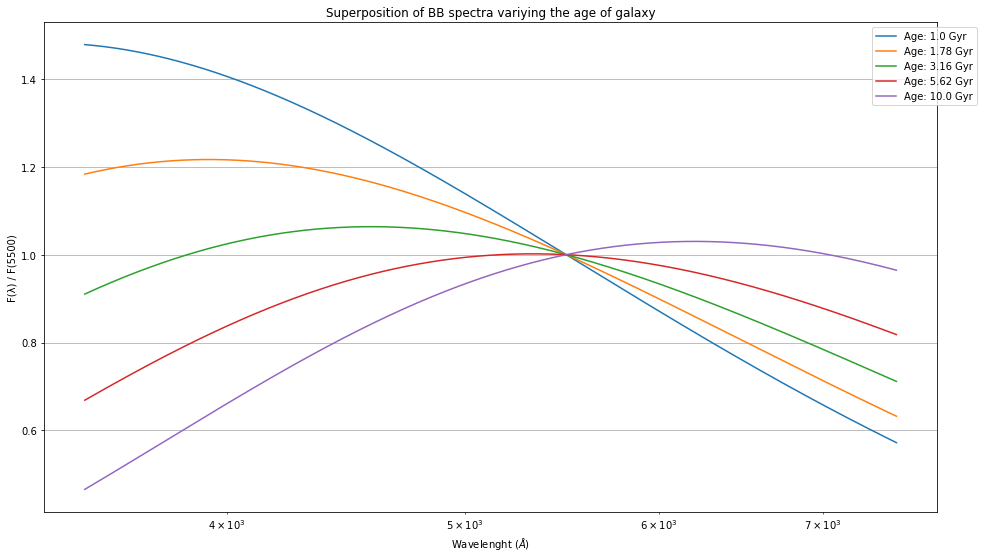

In [36]:
plt.figure(figsize=(16,9))

for i in range (0, n_ages):
    plt.semilogx(wave, flux[i]/normalization[i], label = 'Age: {} Gyr'.format((round(ages[i], 2))))
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.xlabel('Wavelenght ($\AA$)')
    plt.ylabel('F(\u03BB) / F(5500)')
    plt.grid()

plt.title('Superposition of BB spectra variying the age of galaxy')
plt.show()

In [32]:
n_ebv = 5
ebv = np.linspace(0.1, 1, num=n_ebv)

flux_obs, mitigation_factor, normalization_dust = Mitigation(flux[0], wave, n_ebv)

print(ebv)
print(flux_obs)
print(mitigation_factor)
print(normalization_dust)

[0.1   0.325 0.55  0.775 1.   ]
[[3.31339232e+09 3.31369108e+09 3.31398874e+09 ... 1.74928727e+09
  1.74887992e+09 1.74847266e+09]
 [9.23342944e+08 9.23694926e+08 9.24046649e+08 ... 9.79002533e+08
  9.78874345e+08 9.78746143e+08]
 [2.57307952e+08 2.57480947e+08 2.57653926e+08 ... 5.47906553e+08
  5.47890665e+08 5.47874746e+08]
 [7.17039995e+07 7.17730890e+07 7.18422016e+07 ... 3.06640260e+08
  3.06662630e+08 3.06684976e+08]
 [1.99817515e+07 2.00068252e+07 2.00319165e+07 ... 1.71613660e+08
  1.71643678e+08 1.71673681e+08]]
[[0.56672636 0.56679965 0.56687293 ... 0.77261945 0.77265446 0.77268946]
 [0.15792962 0.15799601 0.15806241 ... 0.43240262 0.4324663  0.43252997]
 [0.04401024 0.04404156 0.04407288 ... 0.24199756 0.24205788 0.24211819]
 [0.01226433 0.01227663 0.01228894 ... 0.13543586 0.13548343 0.135531  ]
 [0.0034177  0.00342212 0.00342655 ... 0.07579776 0.07583211 0.07586647]]
[0.68878612 0.29769686 0.12866609 0.05561014 0.02403498]


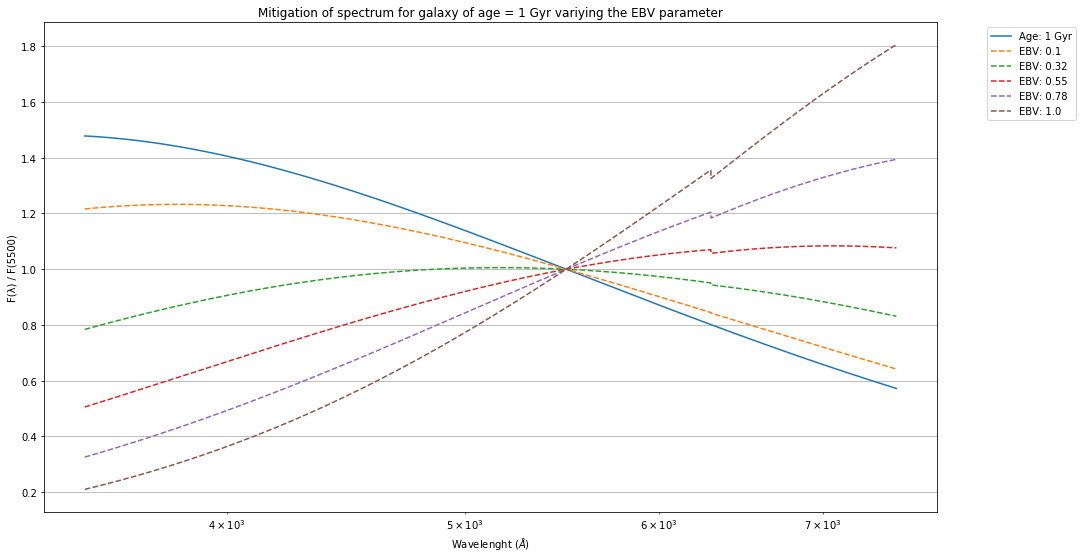

In [38]:
plt.figure(figsize=(16,9))
plt.semilogx(wave, flux[0]/normalization[0], label = 'Age: 1 Gyr')

for i in range (0, n_ebv):
    plt.semilogx(wave, flux_obs[i]/(normalization[0]*normalization_dust[i]), label = 'EBV: {} '.format((round(ebv[i], 2))), linestyle='--')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.xlabel('Wavelenght ($\AA$)')
    plt.ylabel('F(\u03BB) / F(5500)')
    plt.grid()

plt.title('Mitigation of spectrum for galaxy of age = 1 Gyr variying the EBV parameter')
plt.show()